## LIBRARY

In [111]:
  import os
  import pickle
  import numpy as np
  import tensorflow as tf
  import matplotlib.pyplot as plt

## LOAD THE DATASET

In [112]:
# Directory that holds the data
DATASET_DIR = '/content/drive/MyDrive/Dataset'

# Subdirectories for each class
acne_dir = os.path.join(DATASET_DIR, 'Acne')
dark_circle_dir = os.path.join(DATASET_DIR, 'Dark Circle')
wrinkle_dir = os.path.join(DATASET_DIR, 'Wrinkle')

# os.listdir returns a list containing all files under the given dir
print(f"There are {len(os.listdir(acne_dir))} images belongs to acne.")
print(f"There are {len(os.listdir(dark_circle_dir))} images belongs to dark circle.")
print(f"There are {len(os.listdir(wrinkle_dir))} images belongs to wrinkle.")

There are 300 images belongs to acne.
There are 302 images belongs to dark circle.
There are 300 images belongs to wrinkle.


## PRE PROCESSING

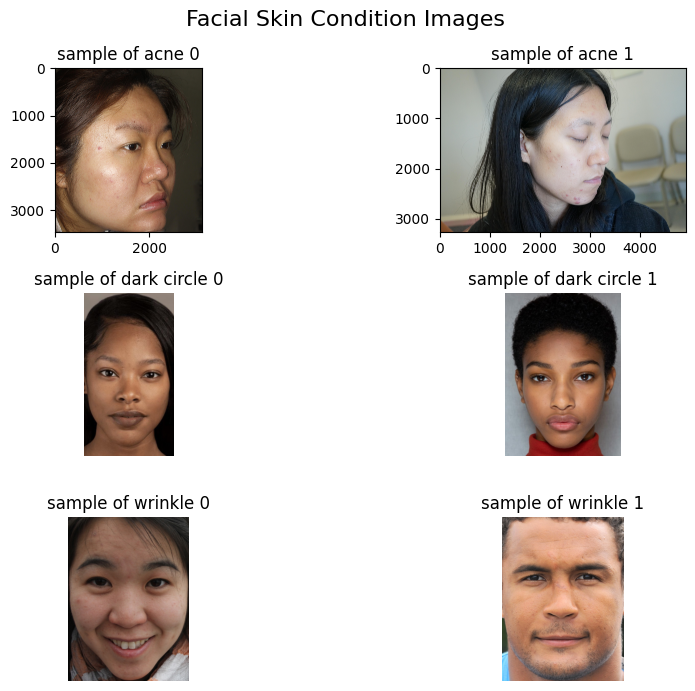

In [113]:
# Get the filenames for cats and dogs images
acne_filenames = [os.path.join(acne_dir, filename) for filename in os.listdir(acne_dir)]
dark_circle_filenames = [os.path.join(dark_circle_dir, filename) for filename in os.listdir(dark_circle_dir)]
wrinkle_filenames = [os.path.join(wrinkle_dir, filename) for filename in os.listdir(wrinkle_dir)]

fig, axes = plt.subplots(3, 2, figsize=(10, 7))
fig.suptitle('Facial Skin Condition Images', fontsize=16)

# Plot the first 2 images of Acne
for i, acne_image in enumerate(acne_filenames[:2]):
    img = tf.keras.utils.load_img(acne_image)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'sample of acne {i}')

# Plot the first 2 images of Dark Circle
for i, dark_circle_image in enumerate(dark_circle_filenames[:2]):
    img = tf.keras.utils.load_img(dark_circle_image)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'sample of dark circle {i}')
    axes[1, i].axis('off')

# Plot the first 2 images of Wrinkle
for i, wrinkle_image in enumerate(wrinkle_filenames[:2]):
    img = tf.keras.utils.load_img(wrinkle_image)
    axes[2, i].imshow(img)
    axes[2, i].set_title(f'sample of wrinkle {i}')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

In [114]:
IMAGE_SIZE = 150
BATCH_SIZE = 64

In [115]:
# Updated ImageDataGenerator with augmentation for training
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,  # Normalize images
    rotation_range=40,  # Random rotation
    width_shift_range=0.2,  # Random horizontal shift
    height_shift_range=0.2,  # Random vertical shift
    shear_range=0.2,  # Random shear
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest',  # Fill missing pixels with nearest value
    validation_split=0.3  # 30% for validation and test
)

# Training generator (with augmentation)
train_generator = train_datagen.flow_from_directory(
    directory=DATASET_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='training',  # 70% of the data for training
    class_mode='categorical'
)

# Validation generator (with rescaling but no augmentation)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3  # 30% for validation and test
)

val_generator = val_datagen.flow_from_directory(
    directory=DATASET_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation',  # 30% for validation
    class_mode='categorical'
)

# Test generator (with rescaling)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1  # 10% for testing
)

test_generator = test_datagen.flow_from_directory(
    directory=DATASET_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation',  # Use part of the validation split for testing
    class_mode='categorical',
    shuffle=False
)

Found 632 images belonging to 3 classes.
Found 270 images belonging to 3 classes.
Found 90 images belonging to 3 classes.


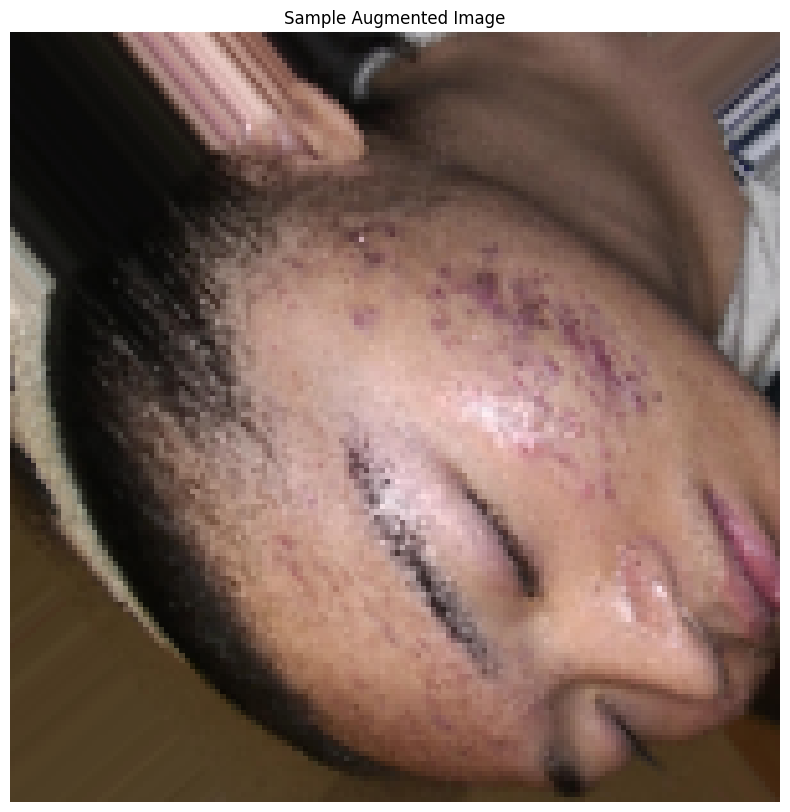

In [118]:
# Select one batch of images from the training generator
batch_images, _ = next(train_generator)

# Display the first image from the batch
plt.figure(figsize=(10, 10))
plt.imshow(batch_images[0])  # display the first augmented image
plt.axis('off')
plt.title('Sample Augmented Image')
plt.show()

## CREATE THE MODEL

In [119]:
def create_model():
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
        include_top=False,  # Don't include the top fully connected layers
        weights='imagenet'  # Use pre-trained weights from ImageNet
    )
    base_model.trainable = False  # Freeze the base model layers to prevent retraining

    model = tf.keras.models.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(3, activation='softmax')  # 3 classes
    ])

    print("Model created successfully.")
    model.summary()
    return model

# Call the function
model = create_model()


<ipython-input-119-226c0ad1c8d7>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Model created successfully.


Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,586,691 (9.87 MB)

 Trainable params: 328,707 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## COMPILE

In [120]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [121]:
example_batch_images, example_batch_labels = next(train_generator)
print(f"Batch labels shape: {example_batch_labels.shape}")

Batch labels shape: (64, 3)


In [122]:
print(train_generator.class_indices)

{'Acne': 0, 'Dark Circle': 1, 'Wrinkle': 2}


In [123]:
# Fetch example batch (images and labels) from the train generator
example_batch_images, example_batch_labels = next(train_generator)

# Check if the model is compatible with the dataset
try:
    model.evaluate(example_batch_images, example_batch_labels, verbose=False)
except Exception as e:
    print("Your model is not compatible with the dataset you defined earlier. "
          "Check that the loss function, last layer and label_mode are compatible with one another.")
    print(f"Error details: {e}")
else:
    predictions = model.predict(example_batch_images, verbose=False)
    print(f"predictions have shape: {predictions.shape}")

predictions have shape: (64, 3)


## TRAINING


In [124]:
history = model.fit(
	train_generator,
	epochs=15,
	validation_data=val_generator,
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 61s 4s/step - accuracy: 0.3689 - loss: 1.7660 - val_accuracy: 0.6704 - val_loss: 0.7858
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - accuracy: 0.5517 - loss: 1.0910 - val_accuracy: 0.8370 - val_loss: 0.5061
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.7375 - loss: 0.6762 - val_accuracy: 0.9037 - val_loss: 0.3590
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - accuracy: 0.7922 - loss: 0.5302 - val_accuracy: 0.9148 - val_loss: 0.2743
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.8745 - loss: 0.3826 - val_accuracy: 0.9222 - val_loss: 0.2561
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.8439 - loss: 0.3639 - val_accuracy: 0.9481 - val_loss: 0.1783
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step - accuracy: 0.8839 - loss: 0.2966 - val_accuracy: 0.9519 - val_loss: 0.1627
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.9095 - loss: 0.2557 - val_accuracy: 0.9593 - val_loss: 0.1429
Epo

## TESTING

In [125]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 775ms/step - accuracy: 1.0000 - loss: 0.0604
Test Loss: 0.0591
Test Accuracy: 100.00%


## CONFUSION MATRIX

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step


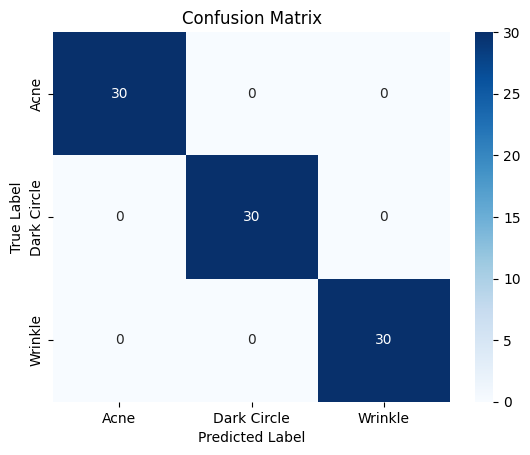

In [126]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [127]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classes))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        30
           2       1.00      1.00      1.00        30

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



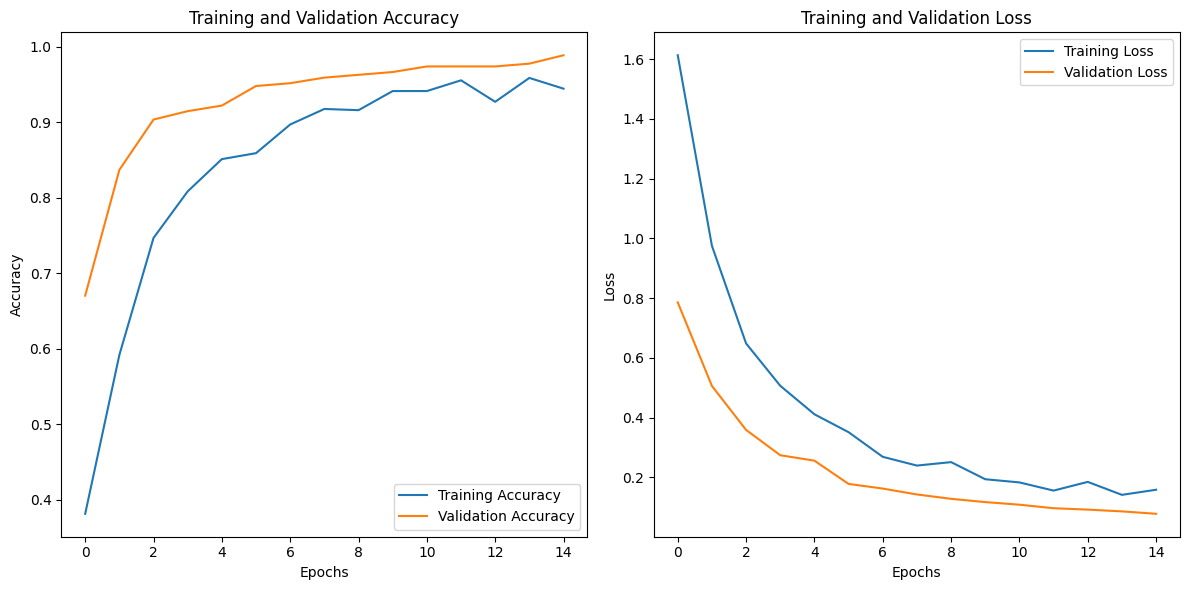

In [128]:
import matplotlib.pyplot as plt

# Assuming you have the `history` object from model.fit()

# Plot accuracy
plt.figure(figsize=(12, 6))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Display the plots
plt.tight_layout()
plt.show()


In [ ]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array
import ipywidgets as widgets
from IPython.display import display

# Define the class labels
class_labels = ['Acne', 'Dark Circle', 'Wrinkle']  # Update this with your actual class labels

# Create an image upload widget
upload_widget = widgets.FileUpload(
    accept='image/*',  # Allow only image files
    multiple=False  # Allow only one file at a time
)

def classify_uploaded_image(change):
    # When a file is uploaded
    uploaded_file = upload_widget.value
    if uploaded_file:
        for filename in uploaded_file:
            # Get the file path and load the image
            img_data = uploaded_file[filename]['content']
            img = load_img(img_data, target_size=(150, 150))
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array /= 255.0  # Normalize the image

            # Make prediction using the trained model
            prediction = model.predict(img_array)
            predicted_class_index = np.argmax(prediction)

            # Get the predicted label
            predicted_label = class_labels[predicted_class_index]

            # Display the uploaded image and the predicted class
            print(f'Predicted class for the uploaded image: {predicted_label}')

            # Optionally, display the uploaded image
            img.show()

# Set the event listener for the upload widget
upload_widget.observe(classify_uploaded_image, names='value')

# Display the widget
display(upload_widget)
